/Users/ascott47/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/ascott47/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


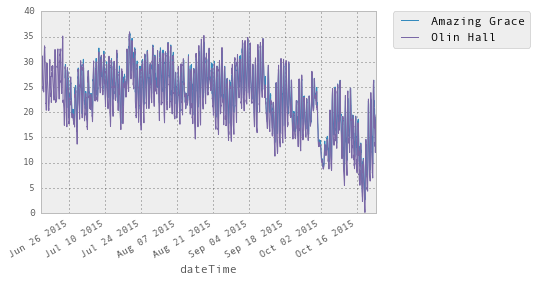

In [2]:
# worksheet for figures from "Constraining intra-urban variability"
# import data
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pylab
from mpl_toolkits.basemap import Basemap
pylab.rcParams['figure.figsize'] = 16, 12
pd.options.display.mpl_style = 'default'
get_ipython().magic(u'matplotlib inline')
import ibuttonplots
import importibuttondata
%matplotlib inline

files = glob.glob('./data/*[tT].csv')
meta0 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
#pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
tempDF0, anomalyDF0, meta0 = importibuttondata.importdata(files, meta0)

#files = glob.glob('./data/*[tT].csv')
files = glob.glob('./data/falldownload/*[tT].csv')
meta1 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
#meta0 = pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
tempDF1, anomalyDF1, meta1 = importibuttondata.importdata(files, meta1)

frames = [tempDF0, tempDF1]
tempDF = pd.concat(frames)
anomalyDF = pd.concat([anomalyDF0, anomalyDF1])
meta = pd.concat([meta0, meta1.loc()[np.setdiff1d(meta1.sensornumber, meta0.sensornumber)]])

# Import Science Center observation data
date_spec = {'Date': [2, 3]}
urbandf = pd.read_csv('./data/observations/urban/2138216847366dat.csv', 
                      sep = ',', 
                      parse_dates = {'Date':[2, 3]},
                      #parse_dates = ['YYYYMMDD', 'HHM'],
                      keep_date_col=True).set_index('Date')
#urbandf.Temp[urbandf.Temp == '****'] = 'NaN' # replace stars with nans
urbandf.Temp = (urbandf.Temp.astype('float')) #-32)*5/9. #change the data to float
urbandf.Temp[urbandf.Temp > 400] = 'NaN' #change unrealistic temp data to nan, data in F so 400 too high
urbandf = urbandf[~((urbandf.index.month == 2) & (urbandf.index.day == 29))] # get rid of leap years
#df.DEWP[df.DEWP == '****'] = 'NaN' # replace stars with nans
#df.DEWP = df.DEWP.astype('float') #change the data to float
urbandf = urbandf.resample('H')
urbandf.rename(columns = {'Temp' : 'TEMP'}, inplace = True)
urbandf.index = urbandf.index - pd.DateOffset(hours  = 4)

import sqlite3
conn = sqlite3.connect('amazinggrace-weewx.sdb')
amazinggracedf = pd.read_sql_query('SELECT * from archive', conn)
amazinggracedf['dateTime']=pd.to_datetime(amazinggracedf['dateTime'], unit='s')
amazinggracedf.outTemp = (amazinggracedf.outTemp-32)*5./9.
amazinggracedf = amazinggracedf.set_index('dateTime')
amazinggracedf.index = amazinggracedf.index - pd.DateOffset(hours  = 5)

conn = sqlite3.connect('olinhall-weewx.sdb')
olinhalldf = pd.read_sql_query('SELECT * from archive', conn)
olinhalldf['dateTime']=pd.to_datetime(olinhalldf['dateTime'], unit='s')
olinhalldf.outTemp = (olinhalldf.outTemp-32)*5./9.
olinhalldf = olinhalldf.set_index('dateTime')
olinhalldf.index = olinhalldf.index - pd.DateOffset(hours  = 5)

#amazinggracedf.outTemp.plot(label = 'Amazing Grace')
#plt.hold(True)
#olinhalldf.outTemp.plot(label = 'Olin Hall')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

amazinggracedf = amazinggracedf.resample('H')
olinhalldf = olinhalldf.resample('H')

# categorize sensors
ebaltsensorsi = np.where(meta['location:Longitude']>= -76.6125831)#-76.61)# -76.6072591 )
parksi = np.where((meta['landcoverclass'] != 'impervious') & (meta['location:Longitude']>= -76.6125831)) # -76.61) )
plt.scatter(meta['location:Longitude'].iloc[ebaltsensorsi],
            meta['location:Latitude'].iloc[ebaltsensorsi], s = 100)
plt.scatter(meta['location:Longitude'].iloc[parksi],
            meta['location:Latitude'].iloc[parksi], color = 'g')

parksensors = meta.sensornumber.iloc[parksi]
ebaltsensors = meta.sensornumber.iloc[ebaltsensorsi]
nonparks = np.setdiff1d(ebaltsensors, parksensors)

selected = ebaltsensors

In [26]:
#Results: compute statistics 
#perform a t-test
from scipy import stats
stats.ttest_ind(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean(), 
                     tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean(),
                     equal_var = False)

2015-06-01  to  2015-09-25
     Total Imp.  Green Difference
Mean 21.10 21.66 20.74 0.92
SD    0.92  0.36 0.67 -0.31
range of the data is 4.15393244616


In [27]:
# table of mean/ std deviation
# standard deviation computed to show sensor-to sensor variability, not variability in time
startdate = '2015-06-01'
enddate = '2015-09-25'
print startdate, " to " , enddate
print "    ", "Total", "Imp. ", "Green", "Difference"
print "Mean", "%2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').mean().mean(), "%2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().mean(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().mean(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().mean()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().mean())
print "SD  ", " %2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').mean().std(), " %2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().std(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().std(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').mean().std()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').mean().std())
print 'range of the data is', tempDF[startdate:enddate].resample('D', how = 'min').mean().max()-tempDF[startdate:enddate].resample('D', how = 'min').mean().min()

2015-06-01  to  2015-09-25
     Total Imp.  Green Difference
Mean 21.10 21.66 20.74 0.92
SD    0.92  0.36 0.67 -0.31
range of the data is 4.15393244616


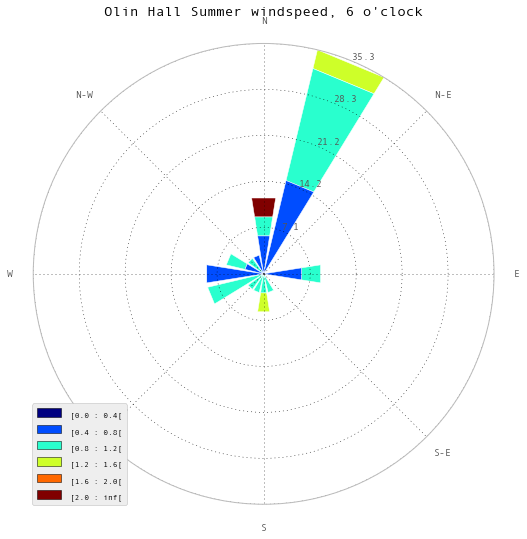

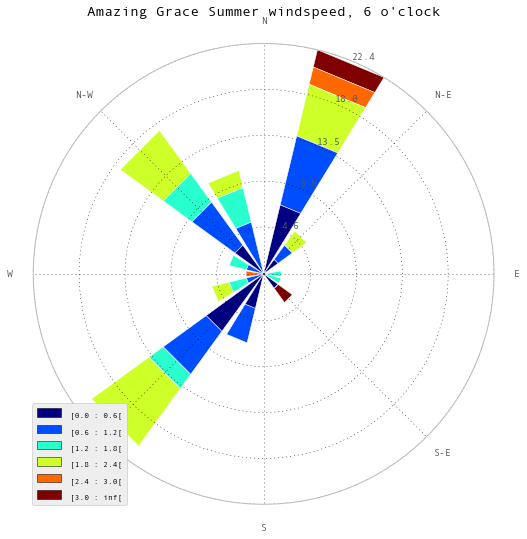

In [28]:
from windrose import WindroseAxes
startdate = '2015-06-24' 
enddate = '2015-09-25'
hour = 6
ax = WindroseAxes.from_ax()
ax.bar(olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windDir, olinhalldf[olinhalldf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Olin Hall Summer windspeed, %i o\'clock'%hour)

ax = WindroseAxes.from_ax()
ax.bar(amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windDir, 
       amazinggracedf[amazinggracedf.index.hour==hour][startdate:enddate].windSpeed, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title('Amazing Grace Summer windspeed, %i o\'clock'%hour)

/Users/ascott47/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


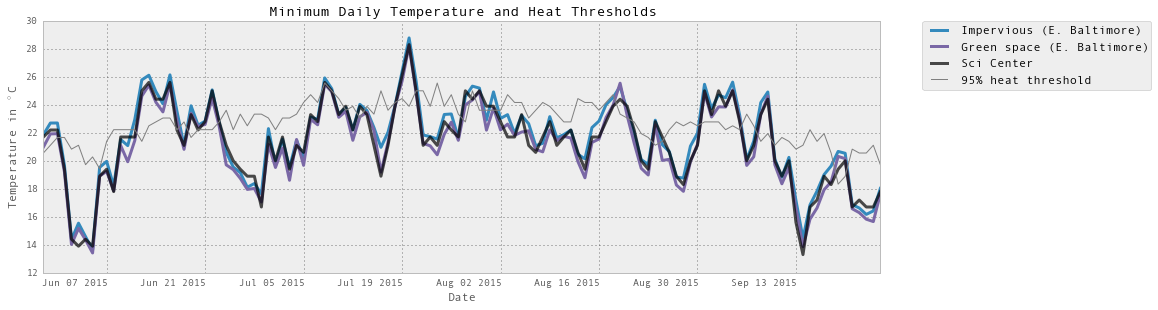

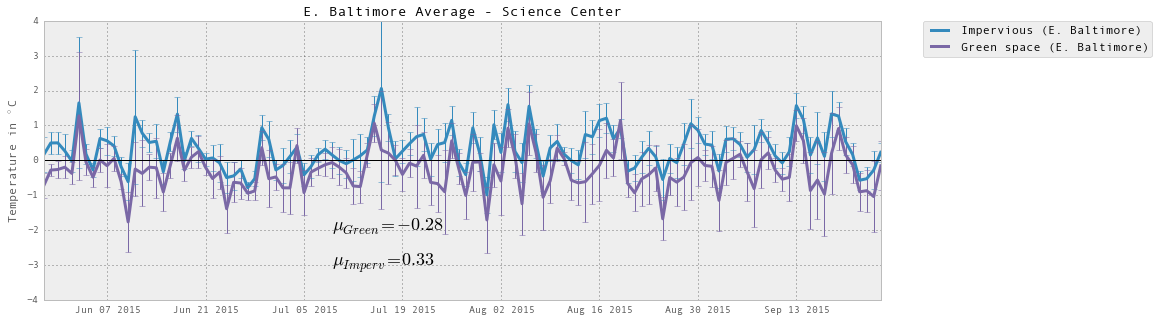

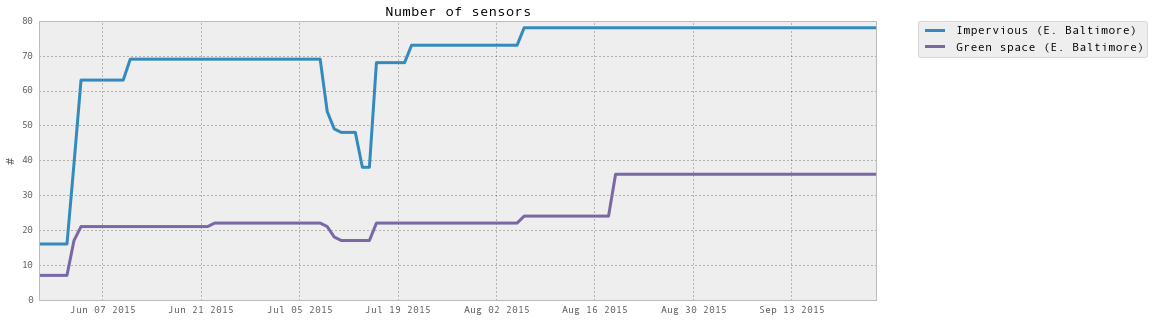

In [4]:
# time series
# Temperature
minthresh = (np.load('BWImindailytempthresholds.npy') -32) *5/9.
fig = plt.figure(figsize=[15,5])
startdate = '2015-05-29' 
enddate = '2015-09-25'
hour = 6

plt.plot(tempDF[startdate:enddate].resample('D',how = 'min').index, 
         tempDF[startdate:enddate].resample('D', how = 'min')[nonparks].mean(axis=1), 
         #'-o', 
         label = 'Impervious (E. Baltimore)', linewidth = 3)

plt.plot(tempDF[startdate:enddate].resample('D', how = 'min').index, 
         tempDF[startdate:enddate].resample('D', how = 'min')[parksensors].mean(axis=1), 
         #'-o', 
         label = 'Green space (E. Baltimore)', linewidth = 3)

urbandf[startdate:enddate].resample('D', how = 'min').TEMP.plot(
    #style = '-o', 
    label = 'Sci Center', linewidth = 3, color = 'k', alpha = .7)
plt.plot(tempDF[startdate:enddate].resample('D').index, minthresh[1][tempDF[startdate:enddate].resample('D', how='min').index.dayofyear-1],
         #'-o', 
         color = 'gray', 
         linewidth = 1, label = '95% heat threshold')
plt.xticks(rotation=0)
plt.xlim([startdate,enddate])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Minimum Daily Temperature and Heat Thresholds')
plt.ylabel('Temperature in $^\circ $C')

# Delta(Temperature)
#diff = tempDF[startdate:enddate][selected].resample('D', how = 'min')-urbandf.TEMP[tempDF[startdate:enddate].resample('D', how = 'min').index]
diff = tempDF[startdate:enddate].resample('D', how = 'min')-urbandf[startdate:enddate].resample('D', how = 'min').TEMP
fig = plt.figure(figsize=[15,5])

plt.errorbar(diff.index, diff[nonparks].mean(axis=1), yerr = diff[nonparks].std(axis=1),
              color = pd.tools.plotting._get_standard_colors(3)[0], linewidth = 1)
plt.plot(diff.index, diff[nonparks].mean(axis=1),
         label = 'Impervious (E. Baltimore)',
          color = pd.tools.plotting._get_standard_colors(3)[0], 
          linewidth = 3, )

plt.errorbar(diff.index, diff[parksensors].mean(axis=1),yerr = diff[parksensors].std(axis=1),
    linewidth = 1, 
    color = pd.tools.plotting._get_standard_colors(3)[1] )

plt.plot(diff.index, diff[parksensors].mean(axis=1), label = 'Green space (E. Baltimore)',
         linewidth = 3,  color = pd.tools.plotting._get_standard_colors(3)[1])


#plt.plot(diff.index, diff[parksensors].mean(axis=1), label = 'Green space (E. Baltimore)',linewidth = 3)
#plt.plot(diff.index, diff[nonparks].mean(axis=1), label = 'Impervious (E. Baltimore)', linewidth = 3)
plt.axhline(0, color ='k')
lgd = plt.legend(selected, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 6)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('E. Baltimore Average - Science Center')
plt.ylabel('Temperature in $^\circ $C')
#plt.xticks(rotation=30)
plt.ylim([-4,4])

plt.text('2015-07-09', -2, '$ \mu_{Green} = %2.2f$'%diff[parksensors].mean(axis=1).mean(), 
         fontsize = 18)
plt.text('2015-07-09', -3, '$ \mu_{Imperv} = %2.2f$'%diff[nonparks].mean(axis=1).mean(), 
         fontsize = 18)
plt.show()


# Number of sensors
fig = plt.figure(figsize=[15,5])
plt.plot(diff.index, (~np.isnan(diff[nonparks])).sum(axis=1), 
         label = 'Impervious (E. Baltimore)', linewidth = 3,)
plt.plot(diff.index, (-np.isnan(diff[parksensors])).sum(axis=1), 
         label = 'Green space (E. Baltimore)', linewidth = 3,)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Number of sensors')
plt.ylabel('#')
plt.show()

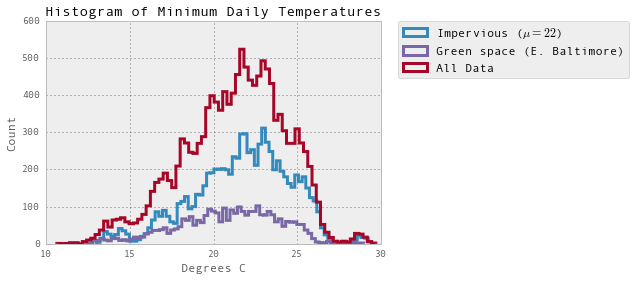

In [7]:
# histogram 
startdate = '2015-'
enddate = '2015-09-25'
M = 75 

data = tempDF[startdate:enddate][nonparks].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, 
                          label = 'Impervious ($\mu = %2.f$)'%(data.mean()))

data = tempDF[startdate:enddate][parksensors].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, 
                          label = 'Green space (E. Baltimore)')


data = tempDF[startdate:enddate].resample('D', how = 'min').values
data = data[~np.isnan(data)] 
n,bins, patches= plt.hist(data,M, histtype='step', linewidth = 3, label = 'All Data')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Histogram of Minimum Daily Temperatures')
plt.xlabel('Degrees C')
plt.ylabel('Count')

In [ ]:
# mapmean 

In [103]:
hwthresh = minthresh[1][tempDF[startdate:enddate].resample('D', how='min').index.dayofyear-1]
#print hwthresh.shape, tempDF[nonparks][startdate:enddate].resample('D', how = 'min').mean(axis=1).shape
hwindex = np.where(tempDF[startdate:enddate].resample('D', how = 'min').mean(axis=1) >= hwthresh)
hwdays = tempDF[startdate:enddate].resample('D', how = 'min').index[hwindex]
print startdate, " to " , enddate, "heatwave days (n= %i/%i)"%(hwdays.shape[0],  tempDF[nonparks][startdate:enddate].resample('D', how = 'min').index.shape[0]-hwdays.shape[0])
print "    ", "Total", "Imp. ", "Green", "Difference"
print "Mean", "%2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[hwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().mean(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().mean()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().mean())
print "SD  ", " %2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[hwdays].mean().std(), " %2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().std(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().std(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[hwdays].mean().std()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[hwdays].mean().std())

nonhwdays = np.setdiff1d(tempDF[startdate:enddate].resample('D', how = 'min').index, hwdays )
print startdate, " to " , enddate, " non- heatwave days (n= %i/%i)"%(nonhwdays.shape[0],  tempDF[nonparks][startdate:enddate].resample('D', how = 'min').index.shape[0])
print "    ", "Total", "Imp. ", "Green", "Difference"
print "Mean", "%2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[nonhwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().mean(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().mean(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().mean()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().mean())
print "SD  ", " %2.2f"%tempDF[startdate:enddate].resample('D', how = 'min').loc[nonhwdays].mean().std(), " %2.2f"%tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().std(), "%2.2f"%tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().std(), "%2.2f"%(tempDF[startdate:enddate][nonparks].resample('D', how = 'min').loc[nonhwdays].mean().std()-tempDF[startdate:enddate][parksensors].resample('D', how = 'min').loc[nonhwdays].mean().std())

2015-05-29  to  2015-09-25 heatwave days (n= 35/85)
     Total Imp.  Green Difference
Mean 23.92 24.37 23.70 0.68
SD    0.78  0.31 0.47 -0.16
2015-05-29  to  2015-09-25  non- heatwave days (n= 85/120)
     Total Imp.  Green Difference
Mean 19.99 20.58 19.44 1.14
SD    1.00  0.41 0.95 -0.54


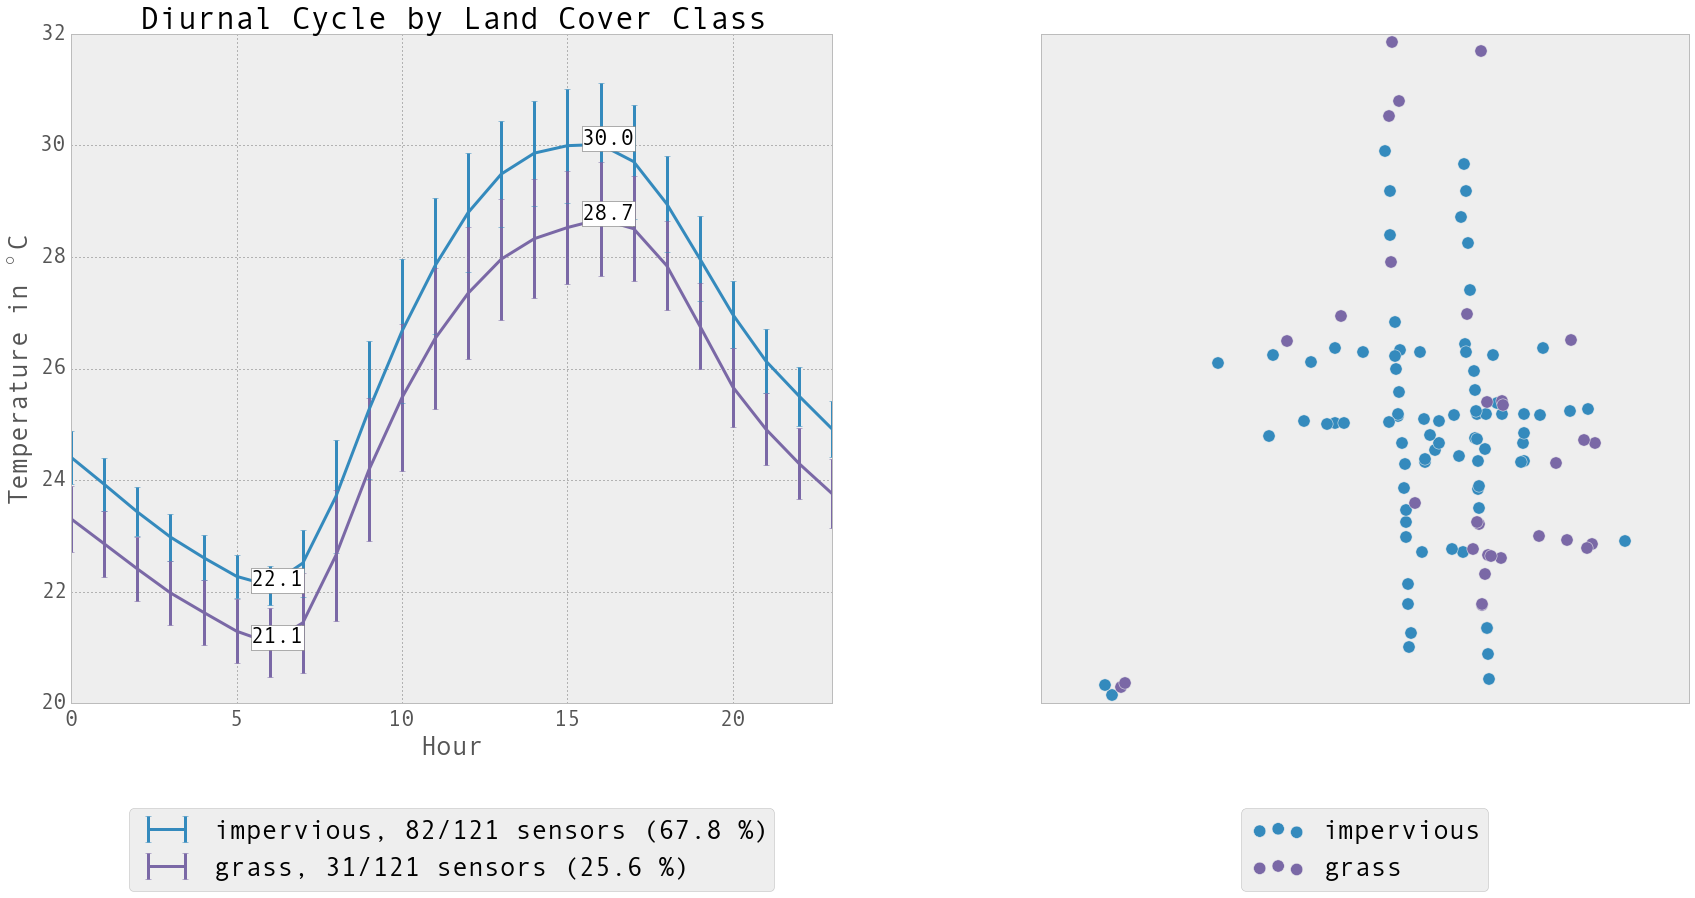

In [104]:
diurnalDF =  tempDF[selected][startdate:enddate]
diurnalDF["hour"] = tempDF[startdate:enddate].index.hour
diurnalDF.set_index("hour")
ibuttonplots.diurnalplots(diurnalDF, meta.loc[selected],'landcoverclass')